In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import catboost as cb
import xgboost as xgb
import shap

from xgboost import XGBRegressor 
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.inspection import permutation_importance

from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [2]:
pd.set_option('display.max_column',None)

In [3]:
#load data
dataset = pd.read_csv("finaldata.csv")
dataset.head(1)

,url,rating,type_airbnb,guests,number_of_beds,number_of_bedrooms,number_of_bathrooms,price_per_night,latitude,longitude,rating_cleanliness,rating_accuracy,rating_communication,rating_location,rating_checkin,rating_value,population,area,travelers_2019,foreign_travelers,covid_total,covid_active,superhost,host_identity_verified,sound_system,child_friendly,fireplace,hygiene_kit,washing_machine,beddings,fire_safety_equipment,clothes_storage,kettle,waterfront,compactor,security_cameras,sauna,parking,game_console,gym,balcony,piano,swimming_pool,indoor_games,wifi,hair_dryer,bathtub,hot_water,iron,safe,keypad,kitchen,tv,refrigerator,streaming_service,airconditioning,oven,grill,utensils,bidet,breakfast,staff,fan,heating,dedicated_workspace,dining_table,cooking_basics,elevator,garden,first_aid_kit,entire_home,enhanced_clean,cancellation_policy,experienced_host,free_parking_on_premises,great_checkin_experience,great_communication,great_location,highly_rated_host,house_rules,laptop_friendly_workspace,outstanding_hospitality,pets_allowed,self_checkin,sparkling_clean,is_shared_room,is_private_room,num_nearby_listings,num_nearby_tourist_spots_3km,num_nearby_tourist_spots_5km,num_nearby_malls_5km,num_nearby_supermarkets_3km,num_nearby_supermarkets_5km,num_nearby_restaurants_3km,num_nearby_restaurants_5km,num_nearby_public_transpo_5km,distance_airport_kms,province,Abra,Agusan del Norte,Agusan del Sur,Aklan,Albay,Antique,Apayao,Aurora,Bataan,Batanes,Batangas,Benguet,Biliran,Bohol,Bukidnon,Bulacan,Cagayan,Caloocan City,Camarines Norte,Camarines Sur,Camiguin,Capiz,Catanduanes,Cavite,Cebu,Compostela Valley,Cotabato,Davao Occidental,Davao Oriental,Davao del Norte,Davao del Sur,Dinagat Islands,Eastern Samar,Guimaras,Ifugao,Ilocos Norte,Ilocos Sur,Iloilo,Isabela,Kalinga,La Union,Laguna,Lanao del Norte,Lanao del Sur,Las Piñas City,Leyte,Maguindanao,Makati City,Malabon City,Mandaluyong City,Manila City,Marikina City,Marinduque,Masbate,Misamis Occidental,Misamis Oriental,Mountain Province,Muntinlupa City,Navotas City,Negros Occidental,Negros Oriental,Northern Samar,Nueva Ecija,Nueva Vizcaya,Occidental Mindoro,Oriental Mindoro,Palawan,Pampanga,Pangasinan,Parañaque City,Pasay City,Pasig City,Pateros,Quezon,Quezon City,Quirino,Rizal,Romblon,Samar,San Juan City,Sarangani,Siquijor,Sorsogon,South Cotabato,Southern Leyte,Sultan Kudarat,Surigao del Norte,Surigao del Sur,Taguig City,Tarlac,Valenzuela City,Zambales,Zamboanga Sibugay,Zamboanga del Norte,Zamboanga del Sur,num_reviews,within_3km_from_highway,within_750m_from_coast,type_airbnb_label,province_label,private_room,private_room_in_cave,shared_room,houseboat,campsite,earth_house,entire_place,entire_resort,entire_villa,farm_stay,island
0,https://www.airbnb.com/rooms/39300057?previous...,NaN,hut,2,0,1,1.0,1900,9.13261,123.6001,NaN,NaN,NaN,NaN,NaN,NaN,95984,337,168366,85713,89,14,1,0,0,0,0,1,0,1,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,2,5,0,0,0,0,2,0,39.603528,Siquijor,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,7,82,0,0,0,0,0,0,1,0,0,0,0


In [4]:
Y = dataset['price_per_night']
Y.head(5)

0    1900
1     850
2     506
3    1400
4     750
Name: price_per_night, dtype: int64

In [5]:
# the independent variables set
X = dataset.drop(['price_per_night'],axis=1)

In [6]:
X = X.drop(columns=['url','rating','type_airbnb',\
                    'province', 'is_shared_room', 'is_private_room', 'num_nearby_tourist_spots_3km',\
                    'num_nearby_supermarkets_3km', 'num_nearby_restaurants_3km','entire_home',\
                    'latitude', 'longitude',\
                    'population','area','covid_total','covid_active',\
                    'type_airbnb_label', 'province_label', 'foreign_travelers'])

In [7]:
X.head()

,guests,number_of_beds,number_of_bedrooms,number_of_bathrooms,rating_cleanliness,rating_accuracy,rating_communication,rating_location,rating_checkin,rating_value,travelers_2019,superhost,host_identity_verified,sound_system,child_friendly,fireplace,hygiene_kit,washing_machine,beddings,fire_safety_equipment,clothes_storage,kettle,waterfront,compactor,security_cameras,sauna,parking,game_console,gym,balcony,piano,swimming_pool,indoor_games,wifi,hair_dryer,bathtub,hot_water,iron,safe,keypad,kitchen,tv,refrigerator,streaming_service,airconditioning,oven,grill,utensils,bidet,breakfast,staff,fan,heating,dedicated_workspace,dining_table,cooking_basics,elevator,garden,first_aid_kit,enhanced_clean,cancellation_policy,experienced_host,free_parking_on_premises,great_checkin_experience,great_communication,great_location,highly_rated_host,house_rules,laptop_friendly_workspace,outstanding_hospitality,pets_allowed,self_checkin,sparkling_clean,num_nearby_listings,num_nearby_tourist_spots_5km,num_nearby_malls_5km,num_nearby_supermarkets_5km,num_nearby_restaurants_5km,num_nearby_public_transpo_5km,distance_airport_kms,Abra,Agusan del Norte,Agusan del Sur,Aklan,Albay,Antique,Apayao,Aurora,Bataan,Batanes,Batangas,Benguet,Biliran,Bohol,Bukidnon,Bulacan,Cagayan,Caloocan City,Camarines Norte,Camarines Sur,Camiguin,Capiz,Catanduanes,Cavite,Cebu,Compostela Valley,Cotabato,Davao Occidental,Davao Oriental,Davao del Norte,Davao del Sur,Dinagat Islands,Eastern Samar,Guimaras,Ifugao,Ilocos Norte,Ilocos Sur,Iloilo,Isabela,Kalinga,La Union,Laguna,Lanao del Norte,Lanao del Sur,Las Piñas City,Leyte,Maguindanao,Makati City,Malabon City,Mandaluyong City,Manila City,Marikina City,Marinduque,Masbate,Misamis Occidental,Misamis Oriental,Mountain Province,Muntinlupa City,Navotas City,Negros Occidental,Negros Oriental,Northern Samar,Nueva Ecija,Nueva Vizcaya,Occidental Mindoro,Oriental Mindoro,Palawan,Pampanga,Pangasinan,Parañaque City,Pasay City,Pasig City,Pateros,Quezon,Quezon City,Quirino,Rizal,Romblon,Samar,San Juan City,Sarangani,Siquijor,Sorsogon,South Cotabato,Southern Leyte,Sultan Kudarat,Surigao del Norte,Surigao del Sur,Taguig City,Tarlac,Valenzuela City,Zambales,Zamboanga Sibugay,Zamboanga del Norte,Zamboanga del Sur,num_reviews,within_3km_from_highway,within_750m_from_coast,private_room,private_room_in_cave,shared_room,houseboat,campsite,earth_house,entire_place,entire_resort,entire_villa,farm_stay,island
0,2,0,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,168366,1,0,0,0,0,1,0,1,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,5,0,0,2,0,39.603528,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,3,2,1,1.0,4.8,4.7,4.7,4.5,4.8,4.8,1088938,1,1,0,0,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,12,1,0,1,3,0,122.730026,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,0,1,1,0,0,0,0,0,0,0,0,0,0
2,6,6,1,6.0,4.7,4.8,4.7,4.8,4.8,4.8,1025407,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,27,4,0,8,96,2,0.807646,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,1,0,0,1,0,0,0,0,0,0,0,0
3,3,2,0,1.0,4.8,4.8,4.8,4.0,4.8,4.8,1025407,1,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,1,0,0,1,1,1,1,1,1,0,1,0,0,0,0,0,1,0,1,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,27,4,0,8,97,3,1.516024,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [8]:
pd.set_option('display.max_rows',None)

In [9]:
pd.DataFrame(X.columns)

,0
0,guests
1,number_of_beds
2,number_of_bedrooms
3,number_of_bathrooms
4,rating_cleanliness
5,rating_accuracy
6,rating_communication
7,rating_location
8,rating_checkin
9,rating_value


In [10]:
X.shape

(11409, 189)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(X, Y,test_size = 0.2, random_state = 100)

In [12]:
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [13]:
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180
    }

In [14]:
# Regression: 
def hyperparameter_tuning(space):
    model = xgb.XGBRegressor(n_estimators = space['n_estimators'],
                             max_depth = int(space['max_depth']),
                             gamma = space['gamma'],
                             reg_alpha = int(space['reg_alpha']),
                             min_child_weight = space['min_child_weight'],
                             colsample_bytree = space['colsample_bytree'])

    evaluation = [( x_train, y_train), ( x_test, y_test)]
    
    model.fit(x_train, y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    pred = model.predict(x_test)
    MSE = mean_squared_error(y_test, pred)
    print ("SCORE:", MSE)
    #change the metric if you like
    return {'loss':MSE, 'status': STATUS_OK, 'model': model}

In [15]:
XGB_model = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9822415012377418,
             gamma=3.2948014398066454, gpu_id=-1, importance_type='gain',
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=4, min_child_weight=10.0, missing=np.nan,
             monotone_constraints='()', n_estimators=180, n_jobs=4,
             num_parallel_tree=1, random_state=0, reg_alpha=144, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [16]:
XGB_model.fit(x_train, y_train)
XGB_pred = XGB_model.predict(x_train)
XGB_pred_test = XGB_model.predict(x_test)

In [17]:
rmse = np.sqrt(mean_squared_error(y_train, XGB_pred))
print("RMSE : % f" %(rmse))

RMSE :  1175.754764


In [18]:
r2_score(y_train, XGB_pred)

0.8493213139658992

In [19]:
rmse = np.sqrt(mean_squared_error(y_test, XGB_pred_test))
print("RMSE : % f" %(rmse))

RMSE :  1804.558471


In [20]:
r2_score(y_test, XGB_pred_test)

0.6494352243297381

In [21]:
MSE = mean_squared_error(y_test, XGB_pred_test)
MSE

3256431.2737164833

In [22]:
XGB_CV = cross_val_score(XGB_model, x_train, y_train)
print(XGB_CV)
print(np.mean(XGB_CV))

[0.59339719 0.4976393  0.58330241 0.56102964 0.53293795]
0.5536612977918987


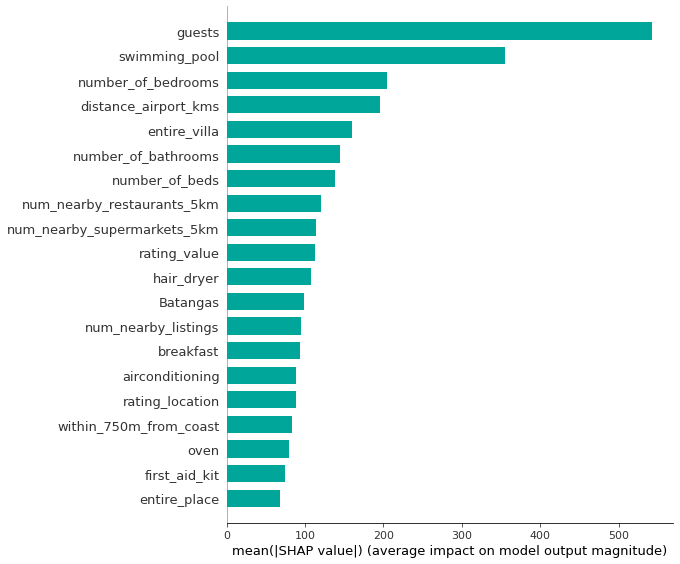

In [23]:
explainer = shap.TreeExplainer(XGB_model)
shap_values = explainer.shap_values(x_test)
shap.summary_plot(shap_values, x_test, plot_type="bar", color="#00a699")

#### Feature Importance

In [24]:
pd.set_option('display.max_rows', 200)

In [25]:
ft_weights_xgb_reg = pd.DataFrame(XGB_model.feature_importances_, columns=['weight'], index=x_train.columns)
ft_weights_xgb_reg.sort_values('weight', ascending=False, inplace=True)
ft_weights_xgb_reg

,weight
swimming_pool,0.082909
within_3km_from_highway,0.075254
entire_villa,0.046971
guests,0.044023
refrigerator,0.038474
Batangas,0.037507
oven,0.030394
entire_place,0.022382
parking,0.021064
Bataan,0.020187
